In [1]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(
    0
)  # We manually set the seed for reproducible results, this is not required

# Challenge 3

Again, we count events including both background and signal, `r`, which follows a Poisson distribution with mean `s + b`. The difference is that now, we don't know the value `s`. However, we do know `b = 2` from independent measurements. A certain measurement gives `r = 10`. Can we determine the value of `s`? With which uncertainty?

The first idea that comes to mind is to estimate `s` as `s_hat = r - b`, so `s_hat = 8`.

Let's assume that `s = 8`. How likely is it to measure `r = 10` (that is, `s_hat = 8`)? This is the conditional probability `P(s_hat = 8;s = 8)`:

In [2]:
from scipy.stats import poisson

s = 8
b = 2
s_hat = 8

prob = poisson(s + b).pmf(s_hat + b)
print(f"Probability is {prob:0.4f}")

Probability is 0.1251


Clearly, we need to give more than just one value for `s`: we can still have smaller and larger values for `s` for which it's reasonable to get `r = 10`. In conclusion, we want to give an *interval* of likely values for `s`. How to determine such interval? First, let's build and plot a matrix with all the conditional probabilities `P(s_hat;s)` for a given background `b = 2`:

In [3]:
N = 22
b = 2

P = np.zeros([N, N])  # probability matrix, NxN

it = np.arange(N)  # range: [0, N)

for s in it:
    P[s, :] = [poisson(s + b).pmf(s_hat + b) for s_hat in it]

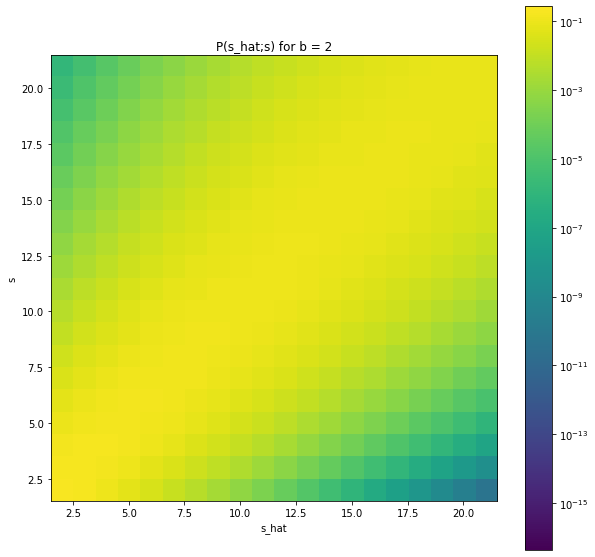

In [4]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(P, origin="lower", cmap="viridis", norm=LogNorm())

ax.set_xlabel("s_hat")
ax.set_ylabel("s")
ax.set_title("P(s_hat;s) for b = 2")

ax.set_xlim([2 - 0.5, 22 - 0.5])
ax.set_ylim([2 - 0.5, 22 - 0.5])

cbar = plt.colorbar(im)

plt.show()

For a given measurement `s_hat = s_0`, we define the interval `[s_lo, s_up]` of possible `s` as follows: 

* `s_lo` is determined by integrating `P(s_hat;s)` over `s_hat` from `s_0` to `inf`: `s_lo` is the value of `s` such that this integral gives `alpha/2`
* `s_up` is determined by integrating `P(s_hat;s)` over `s_hat` from `-inf` to `s_0`: `s_up` is the value of `s` such that this integral gives `alpha/2`

The `1sigma` uncertainty interval is defined by taking `alpha = 0.32`

Let's calculate this for our example `s_hat = s_0 = 10`:

In [5]:
s_0 = 8
alpha = 0.10

# function to calculate the proposed integral
def integral(s, lo_lim, up_lim, P=P):
    # s is the value of signal (we'll iterate over this to find s_lo, s_up)
    # P is our probability matrix
    # lo_lim is the lower integration limit
    # up_lim is the upper integration limit
    res = 0
    for s_hat in np.arange(N):
        # we integrate over s_hat
        if s_hat > lo_lim and s_hat <= up_lim:
            res += P[s, s_hat]
    return res


# let's find s_lo by iterating over all possible values of s
for s_lo in np.arange(N):
    res = integral(s_lo, lo_lim=s_0, up_lim=N)  # N will be our cutoff
    print(f" s = {s_lo}, integral = {res:0.4f}")
    if res >= alpha / 2:
        break

print(f"\n s_lo = {s_lo - 1} \n")

for s_up in reversed(np.arange(N)):
    res = integral(s_up, lo_lim=0, up_lim=s_0)  # 0 will be our cutoff
    print(f" s = {s_up}, integral = {res:0.4f}")
    if res >= alpha / 2:
        break

print(f"\n s_up = {s_up + 1} \n")

 s = 0, integral = 0.0000
 s = 1, integral = 0.0003
 s = 2, integral = 0.0028
 s = 3, integral = 0.0137
 s = 4, integral = 0.0426
 s = 5, integral = 0.0985

 s_lo = 4 

 s = 21, integral = 0.0020
 s = 20, integral = 0.0035
 s = 19, integral = 0.0063
 s = 18, integral = 0.0108
 s = 17, integral = 0.0183
 s = 16, integral = 0.0304
 s = 15, integral = 0.0491
 s = 14, integral = 0.0774

 s_up = 15 



We can repeat this process for all the possible measurements `s_hat = s_0` we can get. Constructing this interval of `s` values for each `s_hat = s_0` produces what we call the Neyman's confidence belt. Before obtaining this interval for our case `b = 2`, let's first integrate our matrix over `s_hat` in the whole range `N`, and for all possible `s`:

In [6]:
for s in np.arange(N):
    print(f" s = {s}, integral = {integral(s, 0, N):0.4f}")

 s = 0, integral = 0.3233
 s = 1, integral = 0.5768
 s = 2, integral = 0.7619
 s = 3, integral = 0.8753
 s = 4, integral = 0.9380
 s = 5, integral = 0.9704
 s = 6, integral = 0.9862
 s = 7, integral = 0.9937
 s = 8, integral = 0.9971
 s = 9, integral = 0.9983
 s = 10, integral = 0.9980
 s = 11, integral = 0.9958
 s = 12, integral = 0.9906
 s = 13, integral = 0.9805
 s = 14, integral = 0.9633
 s = 15, integral = 0.9367
 s = 16, integral = 0.8989
 s = 17, integral = 0.8490
 s = 18, integral = 0.7875
 s = 19, integral = 0.7160
 s = 20, integral = 0.6374
 s = 21, integral = 0.5551


They should be 1 for all values of `s`... This is clearly a cutoff effect: for small values of `s`, `s_hat = -2, -1` (`r = 0, 1`) are very likely, while for large values of `s`, `s_hat > N` become likely. Therefore, extracting `s_lo` and `s_up` won't be accurate for small/large `s_0`, since for small `s_0`, `s_up` will be 'small' and the integrals for `s = 0, 1` will be relevant, while for large `s_0`, `s_lo` will be 'large' and the integrals for `s` close to `N` will be relevant.

We could build a bigger matrix, etc. But for simplicity, we'll just calculate some more intervals for some middle values around `s_0 = 10`:

 For s_0 = 0, s_lo = 0, s_up = 0 
 For s_0 = 1, s_lo = 0, s_up = 5 
 For s_0 = 2, s_lo = 0, s_up = 6 
 For s_0 = 3, s_lo = 1, s_up = 8 
 For s_0 = 4, s_lo = 2, s_up = 9 
 For s_0 = 5, s_lo = 2, s_up = 11 
 For s_0 = 6, s_lo = 3, s_up = 12 
 For s_0 = 7, s_lo = 4, s_up = 13 
 For s_0 = 8, s_lo = 5, s_up = 14 
 For s_0 = 9, s_lo = 5, s_up = 16 
 For s_0 = 10, s_lo = 6, s_up = 17 
 For s_0 = 11, s_lo = 7, s_up = 18 
 For s_0 = 12, s_lo = 8, s_up = 19 
 For s_0 = 13, s_lo = 9, s_up = 21 
 For s_0 = 14, s_lo = 9, s_up = 21 
 For s_0 = 15, s_lo = 10, s_up = 21 
 For s_0 = 16, s_lo = 11, s_up = 21 
 For s_0 = 17, s_lo = 12, s_up = 21 
 For s_0 = 18, s_lo = 13, s_up = 21 
 For s_0 = 19, s_lo = 14, s_up = 21 
 For s_0 = 20, s_lo = 17, s_up = 21 
 For s_0 = 21, s_lo = 21, s_up = 21 


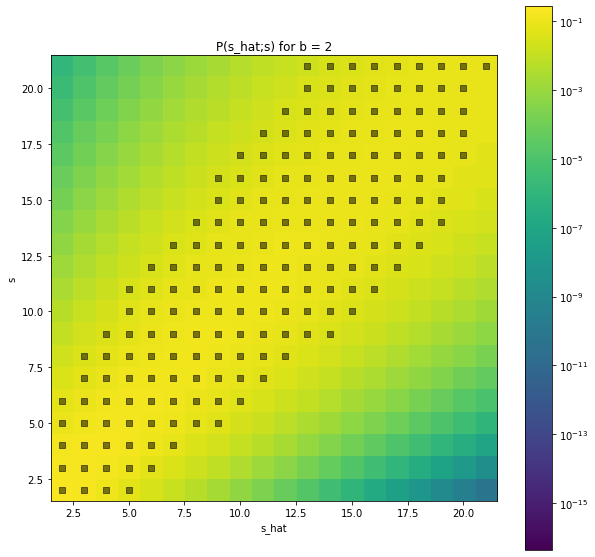

In [7]:
from matplotlib.colors import LogNorm

fig, ax = plt.subplots(figsize=(10, 10))

im = ax.imshow(P, origin="lower", cmap="viridis", norm=LogNorm())


ax.set_xlabel("s_hat")
ax.set_ylabel("s")
ax.set_title("P(s_hat;s) for b = 2")

belt_s_hat = []
belt_s = []

for s_0 in np.arange(0, N):

    for s_lo in np.arange(N):
        res = integral(s_lo, lo_lim=s_0, up_lim=N)  # N will be our cutoff
        if res > alpha / 2:
            break

    for s_up in reversed(np.arange(N)):
        res = integral(s_up, lo_lim=0, up_lim=s_0)  # 0 will be our cutoff
        if res > alpha / 2:
            break

    print(f" For s_0 = {s_0}, s_lo = {s_lo}, s_up = {s_up} ")

    for s_i in range(s_lo, s_up + 1):
        belt_s_hat.append(s_0)
        belt_s.append(s_i)

points = ax.scatter(belt_s_hat, belt_s, marker="s", color="black", alpha=0.5)

cbar = plt.colorbar(im)

ax.set_xlim([2 - 0.5, 22 - 0.5])
ax.set_ylim([2 - 0.5, 22 - 0.5])

plt.show()